### Imports

In [1]:
import pandas as pd
import reciprocalspaceship as rs
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
import json
from scipy import stats
import random
import math
import gemmi
from sklearn.decomposition import PCA
import time
import sys
from scipy.stats import pearsonr
import pickle
from tqdm import tqdm

### Ligand CIF Processing

In [3]:
ligand_cif = []

with open('../PTP1B_DK/ligand_cif_to_dataset_mapping.txt') as f:
    lines = f.readlines()
    
for line in lines:
    dataset, ligands = line[:-1].split(":")
    ligands = list(filter(None,ligands.split(" ")))
    ligand_cif.append([dataset, ligands, 0 if len(ligands) > 0 else 1])
    
ligand_cif = pd.DataFrame(ligand_cif, columns=["Dataset", "Ligands", "Apo"])

apo_samples = ligand_cif[ligand_cif['Apo'] == 1]['Dataset'].tolist()
apo_samples = [sample.split('y')[1] for sample in apo_samples]

samples = ligand_cif['Dataset'].tolist()
samples = [sample.split('y')[1] for sample in samples]

### Reindexing

In [ ]:
!cp ../PTP1B_DK/mtzs/PTP1B-y0001_mrflagsref_idxs.mtz ../PTP1B_DK/mtzs_reindex/PTP1B-y0001_mrflagsref_idxs.mtz

In [15]:
reindexed = {0:[], 1:[]}

for sample in tqdm(samples[1:]):
        
    # currently just re-indexing to the first mtz file
    base = rs.read_mtz(f'../PTP1B_DK/mtzs/PTP1B-y{samples[0]}_mrflagsref_idxs.mtz')[['F-obs', 'SIGF-obs']]
    base_asu = base.hkl_to_asu()
    
    # file not found error
    try: 
        pre_reindex = rs.read_mtz(f'../PTP1B_DK/mtzs/PTP1B-y{sample}_mrflagsref_idxs.mtz')
        
    except:
        continue
        
    pre_reindex_1_asu = pre_reindex.apply_symop(gemmi.Op("x,y,z")).hkl_to_asu()
    pre_reindex_2_asu = pre_reindex.apply_symop(gemmi.Op("-x,-y,z")).hkl_to_asu()

    merged_1 = base_asu.merge(pre_reindex_1_asu, left_index=True, right_index=True, suffixes=(f'_{samples[0]}', f'_{sample}'), check_isomorphous=False)
    merged_2 = base_asu.merge(pre_reindex_2_asu, left_index=True, right_index=True, suffixes=(f'_{samples[0]}', f'_{sample}'), check_isomorphous=False)
    
    corr_1 = np.corrcoef(merged_1[f'F-obs_{samples[0]}'], merged_1[f'F-obs_{sample}'])[0][1]
    corr_2 = np.corrcoef(merged_2[f'F-obs_{samples[0]}'], merged_2[f'F-obs_{sample}'])[0][1]
    
    if corr_1 > corr_2:
        reindexed[0].append(sample)
        pre_reindex_1_asu.write_mtz(f'../PTP1B_DK/mtzs_reindex/PTP1B-y{sample}_mrflagsref_idxs.mtz')
        
    else:
        reindexed[1].append(sample)
        pre_reindex_2_asu.write_mtz(f'../PTP1B_DK/mtzs_reindex/PTP1B-y{sample}_mrflagsref_idxs.mtz')
        
with open('reindex.json', 'w') as fp:
    json.dump(reindexed, fp)


100%|██████████| 1957/1957 [24:45<00:00,  1.32it/s]


### PCA

In [7]:
# write to a file for the intersections of all files
F1 = rs.read_mtz(f'../PTP1B_DK/mtzs/PTP1B-y0001_mrflagsref_idxs.mtz')[['F-obs']]
F1 = F1.rename(columns={'F-obs': 'F-obs_0001'})
for i in tqdm(samples):
        
    try: 
        F2 = rs.read_mtz(f'../PTP1B_DK/mtzs/PTP1B-y{i}_mrflagsref_idxs.mtz')[['F-obs']]
        F2 = F2.rename(columns={'F-obs': f'F-obs_{i}'})
        
    except:
        continue
                
    F1 = F1.merge(F2, left_index=True, right_index=True, check_isomorphous=False)
    
F1.write_mtz(f'../PTP1B_DK/mtzs/intersection.mtz')

100%|██████████| 1958/1958 [10:47<00:00,  3.02it/s]
/n/home10/phyllis/mambaforge/envs/rs/lib/python3.7/site-packages/reciprocalspaceship/dataset.py:296: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset = super().reset_index(level, drop=drop, inplace=inplace, col_level=col_level, col_fill=col_fill)


/n/home10/phyllis/mambaforge/envs/rs/lib/python3.7/site-packages/reciprocalspaceship/io/mtz.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[c.label] = c.array
/n/home10/phyllis/mambaforge/envs/rs/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


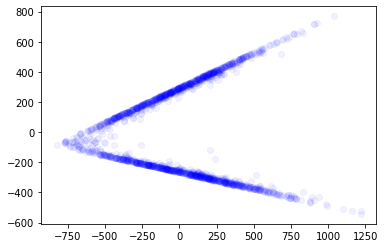

In [4]:
original_intersection = rs.read_mtz('../PTP1B_DK/mtzs/intersection.mtz')
pca = PCA()
principalComponents = pca.fit_transform(original_intersection.T)
principalDf = pd.DataFrame(data = principalComponents)
plt.scatter(principalDf[[0]], principalDf[[1]], c='blue', alpha=0.05)
plt.show()

/n/home10/phyllis/mambaforge/envs/rs/lib/python3.7/site-packages/reciprocalspaceship/io/mtz.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[c.label] = c.array
/n/home10/phyllis/mambaforge/envs/rs/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


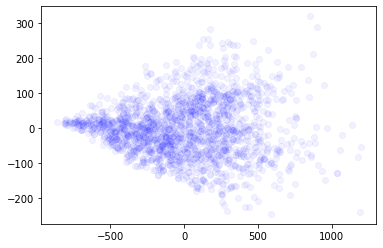

In [5]:
reindex_intersection = rs.read_mtz('../PTP1B_DK/mtzs_reindex/intersection.mtz')
pca = PCA()
principalComponents = pca.fit_transform(reindex_intersection.T)
principalDf = pd.DataFrame(data = principalComponents)
plt.scatter(principalDf[[0]], principalDf[[1]], c='blue', alpha=0.05)
plt.show()

In [6]:
!ls PTP1B_DK/scaled_vector_mtzs | wc -l

ls: cannot access PTP1B_DK/scaled_vector_mtzs: No such file or directory
0
